In [208]:
import pandas as pd
import pingouin as pg
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(rc = {'figure.figsize': (12, 6)}, font_scale = 1.2)

#### **Описание данных**

Ссылка на датафрейм: https://www.kaggle.com/datasets/mirichoi0218/insurance/data 

Рассматриваемый датафрейм содержит данные о людях, обращавшихся в медицинские учреждения за помощью, а так же стоимость оказанных медицинских услуг. Так:  

* ``age`` - возраст человека
* ``sex`` - половая принадлежность
* ``bmi`` - индекс массы тела, дающий представление об отношении веса к росту
* ``children`` - количество детей в семье
* ``smoker`` - курит или нет
* ``region`` - регион проживания в США
* ``charges`` - индивидуальные медицинские расходы

#### **Формулировка цели(ей)**

В рамках настоящего исследования мы хотим предсказать **стоимость оказания медицинских услуг** исходя из возраста, половой принадлежности человека, привычки курить и пр.

#### **Подготовка данных**

Чтение и предосмотр данных

In [2]:
df = pd.read_csv(r'C:\Users\Anatoly\Desktop\Methods\One\insurance.csv')

df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Разведывательный анализ данных (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [5]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
print('Размер датафрейма:', df.shape, '\n')

print('Кол-во уникальных пользователей соответствует кол-ву строк:')
print(df.charges.nunique() == df.shape[0], '\n')

print('Наличие дубликатов:')
print(df.duplicated().sum(), '\n')

print('Наличие пропущенных значений:')
print(df.isna().sum().sum())

Размер датафрейма: (1338, 7) 

Кол-во уникальных пользователей соответствует кол-ву строк:
False 

Наличие дубликатов:
1 

Наличие пропущенных значений:
0


Удаление дубликатов и последующая проверка

In [7]:
df.drop_duplicates(inplace = True)

In [8]:
print('Кол-во уникальных пользователей соответствует кол-ву строк:')
print(df.charges.nunique() == df.shape[0], '\n')

print('Наличие дубликатов:')
print(df.duplicated().sum(), '\n')

Кол-во уникальных пользователей соответствует кол-ву строк:
True 

Наличие дубликатов:
0 



#### **Исследование данных**

Сначала закодируем категориальные переменные (sex, smoker, region) с помощью класса LabelEncoder библиотеки sklearn. Данный класс преобразует n категорий в числа от 1 до n! Дополнительно визуализируем затраты на медицинские услуги в разрезе бывших категориальных признаков

In [9]:
le = LabelEncoder()

Половая принадлежность

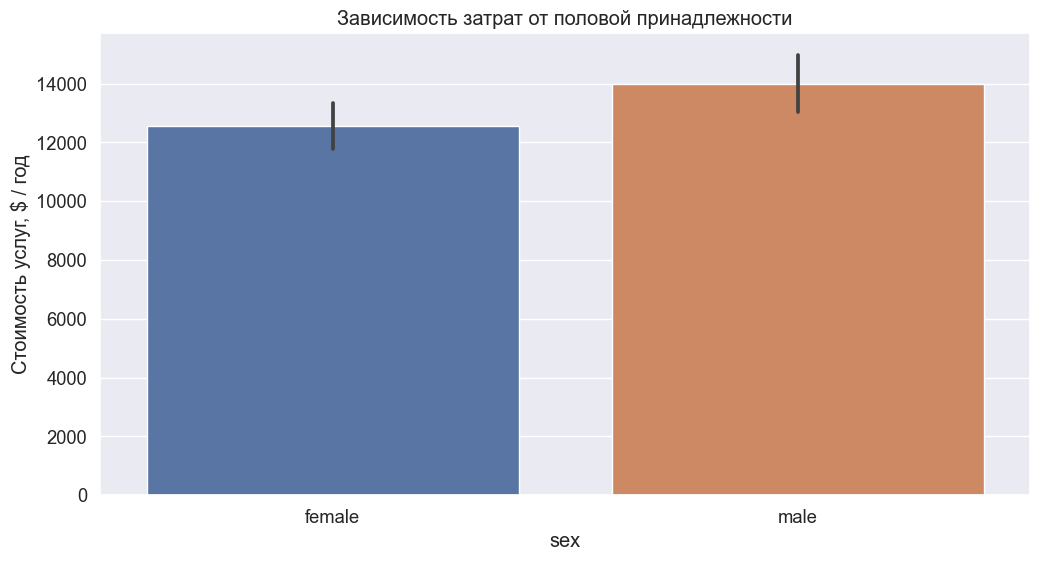

In [10]:
sns.barplot(data = df, x = 'sex', y = 'charges')
plt.title('Зависимость затрат от половой принадлежности')
plt.ylabel('Стоимость услуг, $ / год');

Дополнительно сравним затраты курящих мужчин и женщин

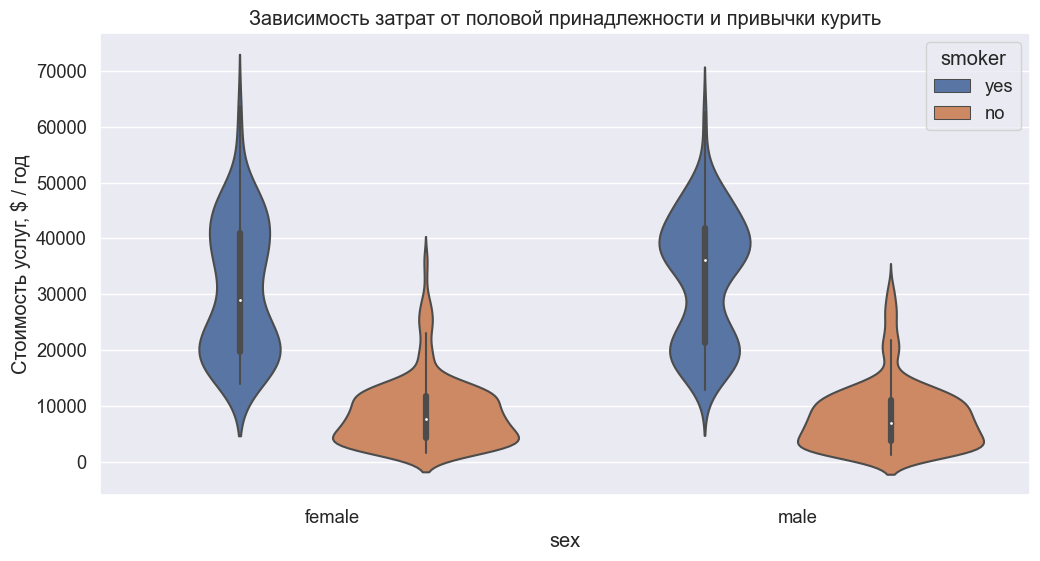

In [11]:
sns.violinplot(data = df, x = 'sex', y = 'charges', hue = 'smoker')
plt.title('Зависимость затрат от половой принадлежности и привычки курить')
plt.ylabel('Стоимость услуг, $ / год');

In [12]:
le.fit(df.sex.drop_duplicates()) 
df.sex = le.transform(df.sex)

Привычка курить

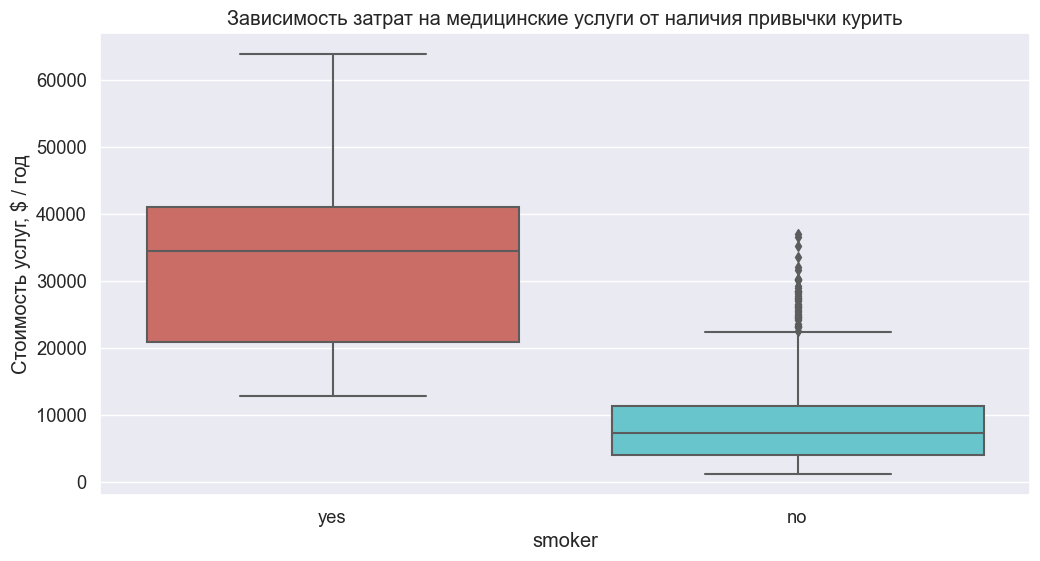

In [13]:
sns.boxplot(data = df, x = 'smoker', y = 'charges', palette = 'hls')
plt.title('Зависимость затрат на медицинские услуги от наличия привычки курить')
plt.ylabel('Стоимость услуг, $ / год');

In [14]:
le.fit(df.smoker.drop_duplicates()) 
df.smoker = le.transform(df.smoker)

Регион проживания

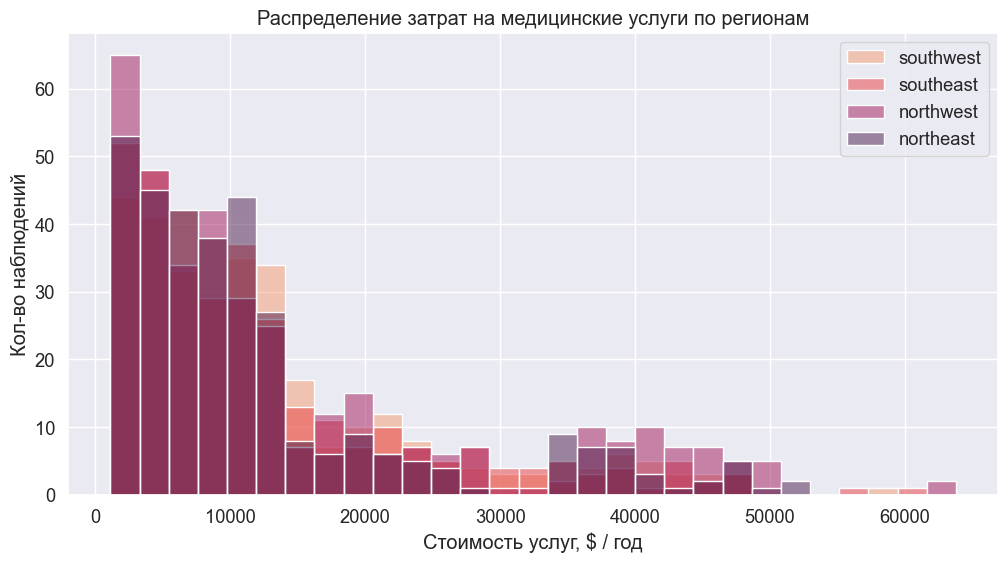

In [15]:
regions = df.region.unique().tolist()
sns.histplot(data = df, x = 'charges', hue = 'region', kde = False, palette = 'rocket');

plt.title('Распределение затрат на медицинские услуги по регионам')
plt.xlabel('Стоимость услуг, $ / год')
plt.ylabel('Кол-во наблюдений')
plt.legend(regions);

In [16]:
le.fit(df.region.drop_duplicates()) 
df.region = le.transform(df.region)

Таким образом, благодаря визуальному анализу данных получилось установить, что курящие люди тратят на медицинские услуги значительно больше средств, чем некурящие. При этом среди некурящих много значений, которые можно было бы посчитать за выбросы, а возможно их попросту сильнее больше, чем курящих. Также violinplot показал, что курящие мужчины тратят больше курящих женщин, но в целом половая принадлежность практически не влияет на показатель, как и регион проживания. Разве что выделяется северо-восточный регион, т.к. в нем наблюдаются самые высокие траты. Еще важно, что мы смогли преобразовать категориальные переменные в количественные, что дает возможность применения линейной регрессии для предсказания стоимости оказания медицинских услуг. Также важно обозначить, итогом совершенных преобразований получились следующие обозначения:  
| Название поля	| Числовое значение | Смысловое значение                       |
|-------------------|--------------|------------------------------------------|
| sex            | 0	       | Женщина                               |
| 	        | 1	   | Мужчина                   |
| smoker	        | 0	       | Не курит            |
| 	        | 1	       | Курит |
| region	        | 0	       | Северо-восток            |
| 	        | 1	       | Северо-запад |
| 	        | 2	       | Юго-восток            |
| 	        | 3	       | Юго-запад |

Далее посмотрим на корреляцию целевой (зависимой) переменной с предикторами и для наглядности построим корреляционную матрицу

In [17]:
df.corr()['charges'].sort_values(ascending = False)

charges     1.000000
smoker      0.787234
age         0.298308
bmi         0.198401
children    0.067389
sex         0.058044
region     -0.006547
Name: charges, dtype: float64

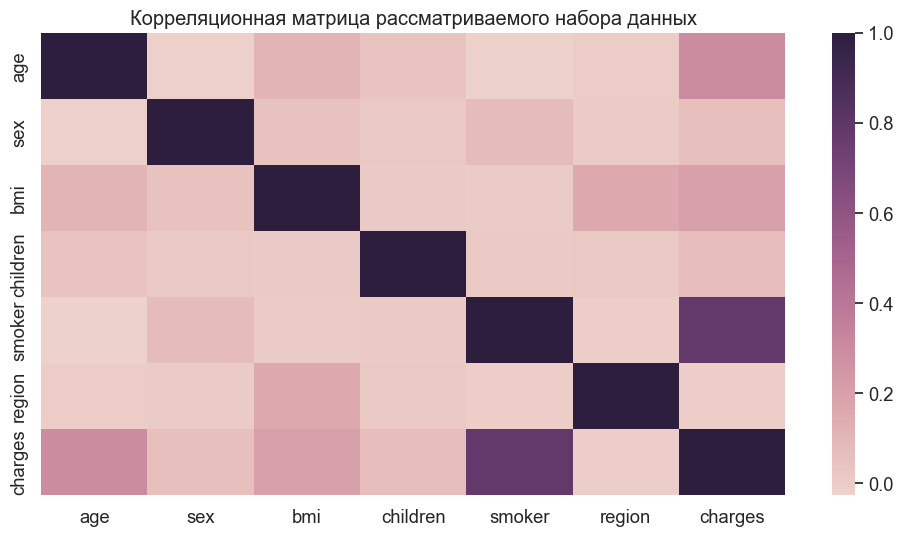

In [18]:
f, ax = plt.subplots()
corr = df.corr()

sns.heatmap(corr, ax = ax, cmap = sns.cubehelix_palette(as_cmap = True))
plt.title('Корреляционная матрица рассматриваемого набора данных');

Так, отчетливо прослеживается взаимосвязь стоимости оказания медицинских услуг и наличия у пациента **привычки курить**. Также достаточное влияние на целевую переменную оказывает **возраст** пациента, меньше - **индекс массы тела**. Подробнее рассмотрим распределение стоимости оказания медицинских услуг в зависимости от наличия привычки курить:

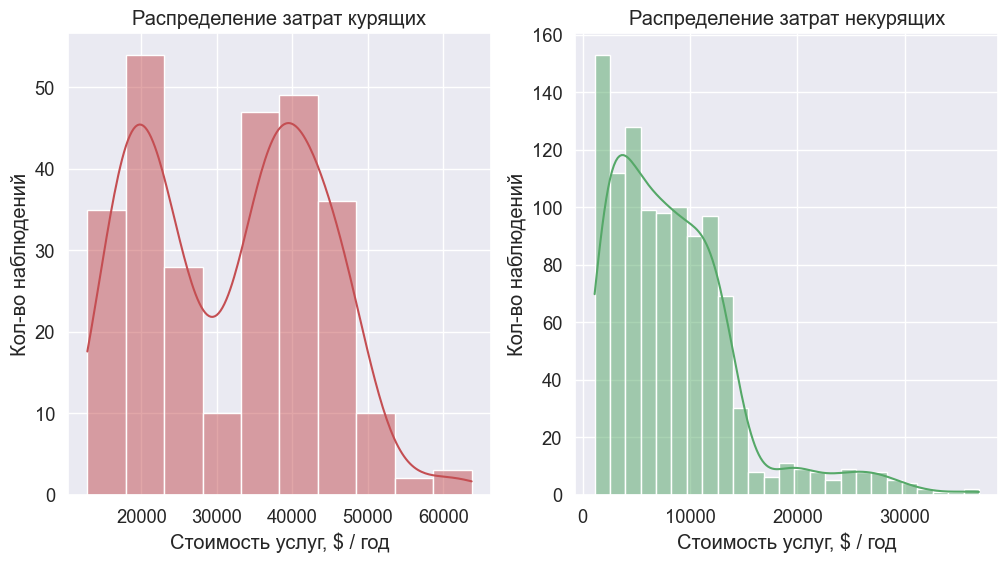

In [19]:
f = plt.figure()

ax_1 = f.add_subplot(121)
ax_2 = f.add_subplot(122)

sns.histplot(df[(df.smoker == 1)]["charges"], color = 'r', ax = ax_1, kde = True)
sns.histplot(df[(df.smoker == 0)]['charges'], color = 'g', ax = ax_2, kde = True)

ax_1.set(title = 'Распределение затрат курящих', xlabel = 'Стоимость услуг, $ / год', ylabel = 'Кол-во наблюдений')
ax_2.set(title = 'Распределение затрат некурящих', xlabel = 'Стоимость услуг, $ / год', ylabel = 'Кол-во наблюдений');

Из графиков видно, первое трат курящих бимодально, а значит курящие чаще всего тратят на медицинские услуги около 20 и 40 тысяч долларов в год, в то время как некурящие - от 8 до 10 тысяч. Дополнительно сравним средние значения выборок:

In [20]:
print('Курящие в среднем тратят:', df.query('smoker == 1').charges.mean())
print('Некурящие в среднем тратят:', df.query('smoker == 0').charges.mean())

Курящие в среднем тратят: 32050.23183153284
Некурящие в среднем тратят: 8440.660306508937


Далее рассмотрим распределение возраста пациентов

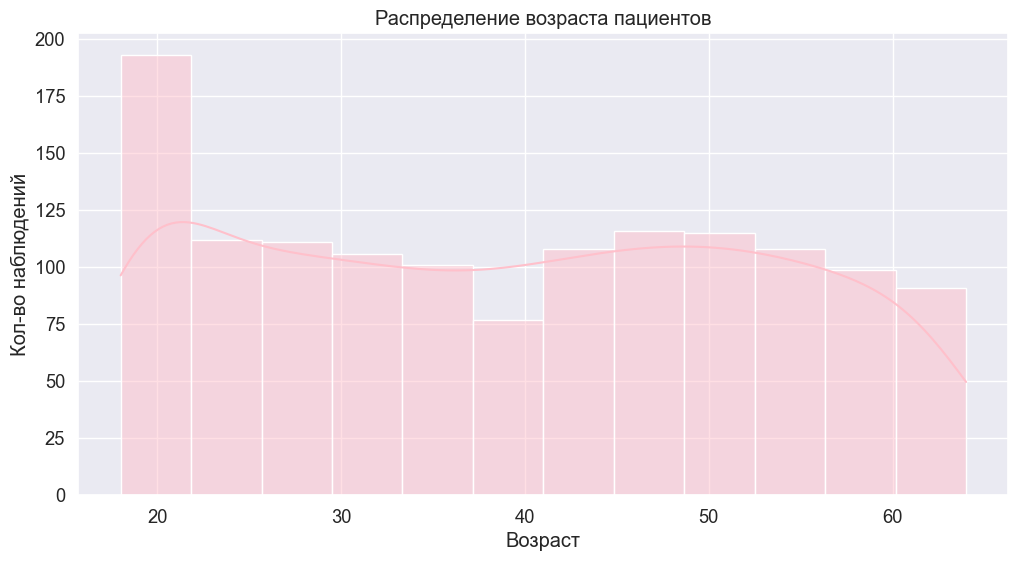

In [21]:
sns.histplot(data = df['age'], kde = True, color = 'pink')
plt.title('Распределение возраста пациентов')
plt.xlabel('Возраст')
plt.ylabel('Кол-во наблюдений');

In [22]:
print('Минимальный возраст:', df['age'].min())
print('Средний возраст:', int(df['age'].mean()))
print('Максимальный возраст:', df['age'].max())

Минимальный возраст: 18
Средний возраст: 39
Максимальный возраст: 64


Особо интересно рассмотреть распределение возраста пациентов в разрезе наличия привычки курить:

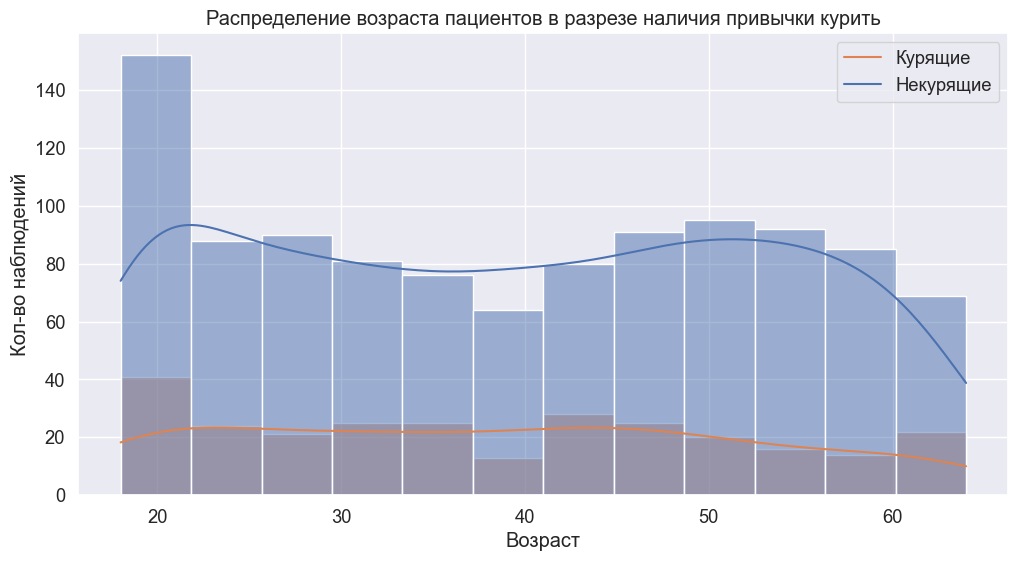

In [23]:
sns.histplot(data = df, x = 'age', hue = 'smoker', kde = True)
plt.title('Распределение возраста пациентов в разрезе наличия привычки курить')
plt.xlabel('Возраст')
plt.ylabel('Кол-во наблюдений')
plt.legend(['Курящие', 'Некурящие']);

In [24]:
print('Минимальный возраст:', df.query('smoker == 0')['age'].min(), '|', df.query('smoker == 1')['age'].min())
print('Средний возраст:', int(df.query('smoker == 0')['age'].mean()), '|', int(df.query('smoker == 1')['age'].mean()))
print('Максимальный возраст:', df.query('smoker == 0')['age'].max(), '|', df.query('smoker == 1')['age'].max())


Минимальный возраст: 18 | 18
Средний возраст: 39 | 38
Максимальный возраст: 64 | 64


In [25]:
df.query('smoker == 0').shape[0]

1063

In [26]:
df.query('smoker == 1').shape[0]

274

Получается, минимальный, средний и максимальный возраст почти одинаковы для курящих и некурящих пацентов, хоть вторых больше чем в 4 раза!

Чтобы посмотреть как возраст и наличие привычки курить коррелируют со стоимостью медицинских услуг, дополнительно построим диаграмму рассеяния и линейный график:


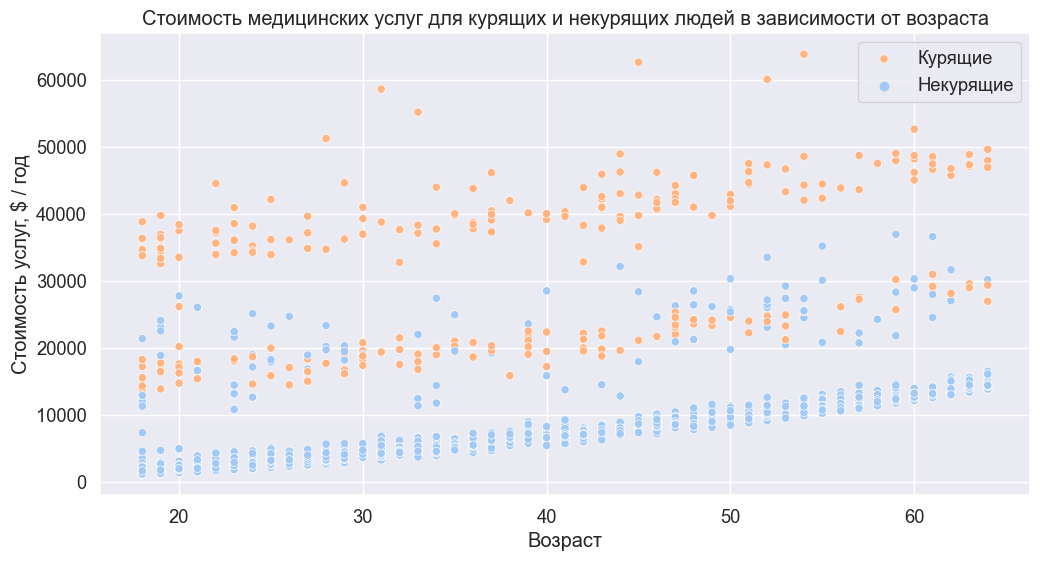

In [27]:
sns.scatterplot(data = df, x = 'age', y = 'charges', hue = 'smoker', palette = 'pastel')
plt.title('Стоимость медицинских услуг для курящих и некурящих людей в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Стоимость услуг, $ / год')
plt.legend(['Курящие', 'Некурящие']);

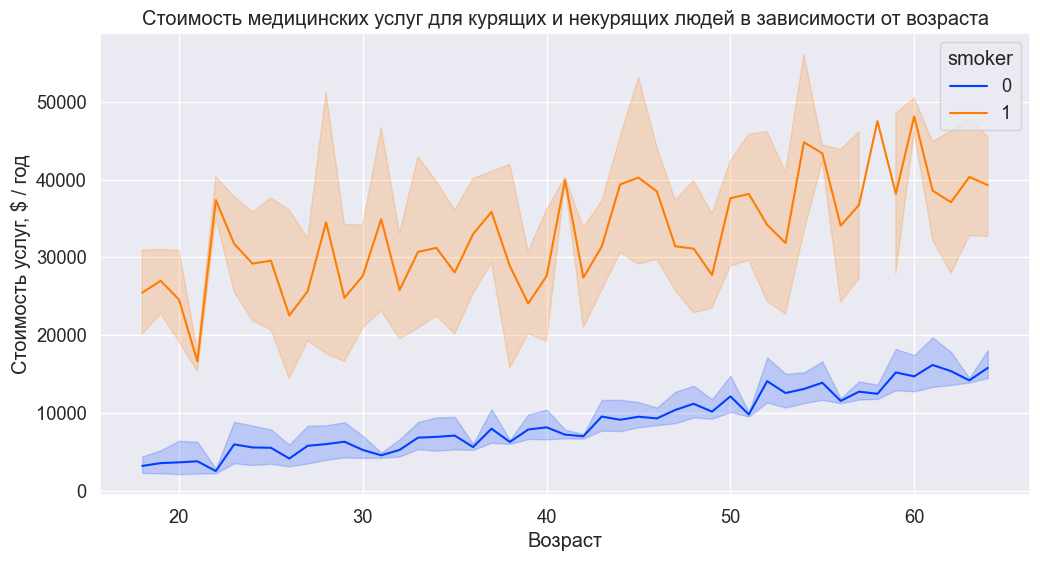

In [28]:
sns.lineplot(data = df, x = 'age', y = 'charges', hue = 'smoker', palette = 'bright')
plt.title('Стоимость медицинских услуг для курящих и некурящих людей в зависимости от возраста')
plt.xlabel('Возраст')
plt.ylabel('Стоимость услуг, $ / год');

Можно сказать, что у некурящих людей стоимость медицинских услуг увеличивается практически пропорционально возрасту в отличие от курящих. У вторых же стоимость растет непрямолинейно, но так же с годами человек начинает тратить на медицину лишь больше!

Также посмотрим на распределение значений индекса массы тела при помощи QQ-графика и гистограммы:

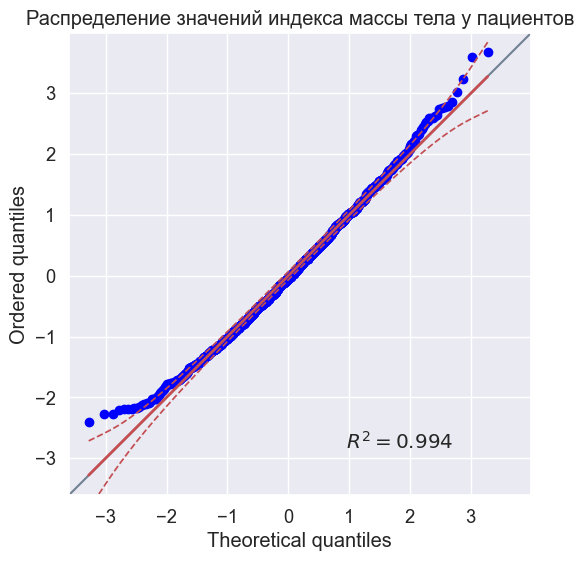

In [29]:
pg.qqplot(df['bmi']);
plt.title('Распределение значений индекса массы тела у пациентов');

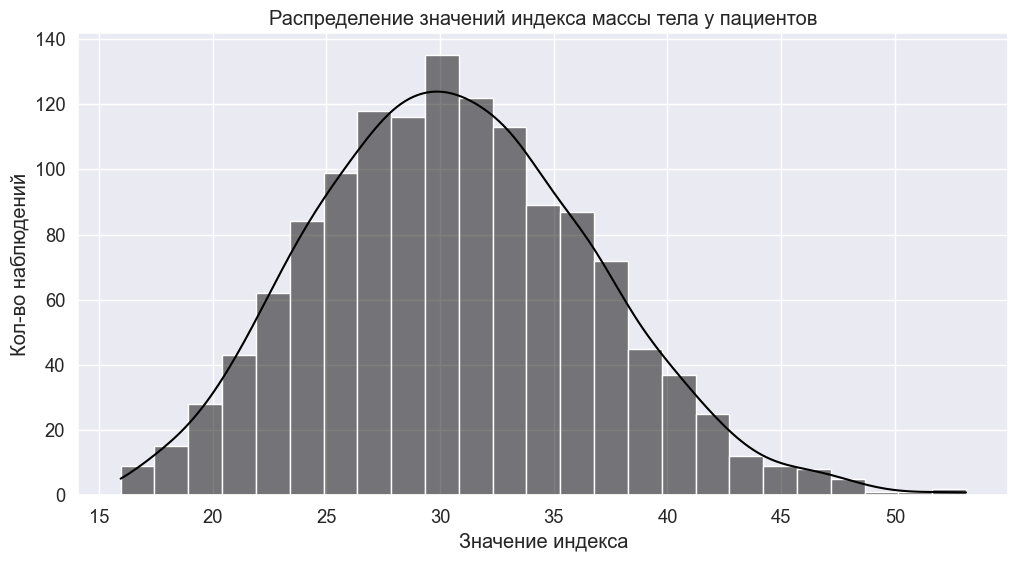

In [30]:
sns.histplot(df.bmi, kde = True, color = 'black');
plt.title('Распределение значений индекса массы тела у пациентов')
plt.xlabel('Значение индекса')
plt.ylabel('Кол-во наблюдений');

Из графиков следует вывод, что в целом данный признак соответствует нормальному распределению. Также имеются незначительные аномальные значения. Так как признак количественный, разделим пациентов на 3 группы. Так, значения индекса превосходящие или равные 3-ему квантилю будут относиться к категории **high**, попавшие в диапазон между 1-м и 3-м квантилями – **normal**, а ниже 1-го квантиля – **low**

In [31]:
df_1 = df.copy()
df_1['bmi_new'] = df_1['bmi'].apply(lambda x: 'normal' if (x >= df_1['bmi'].quantile(0.25)) & (x <= df_1['bmi'].quantile(0.75)) else 'high' if x > df_1['bmi'].quantile(0.75) else 'low')

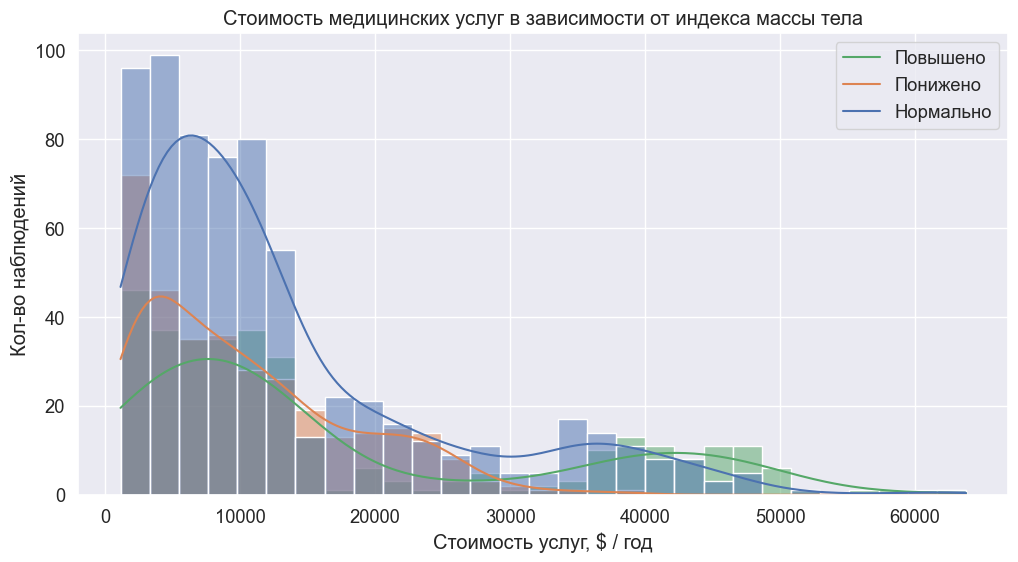

In [230]:
sns.histplot(data = df_1, x = 'charges', hue = 'bmi_new', kde = True)
plt.title('Стоимость медицинских услуг в зависимости от индекса массы тела')
plt.xlabel('Стоимость услуг, $ / год')
plt.ylabel('Кол-во наблюдений')
plt.legend(['Повышено', 'Понижено' , 'Нормально']);

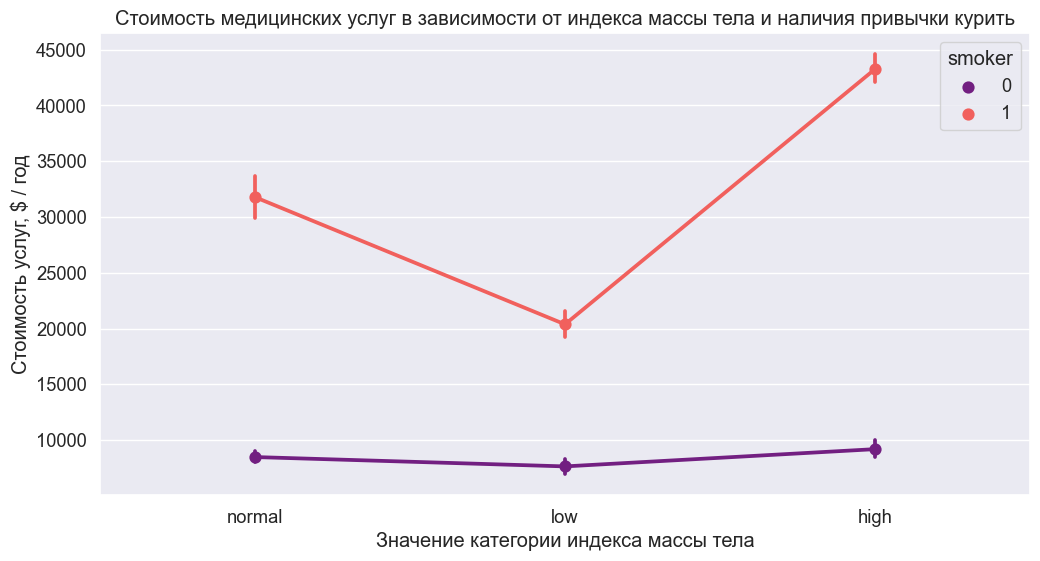

In [220]:
sns.pointplot(data = df_1, x = 'bmi_new', y = 'charges', hue = 'smoker', palette = 'magma')
plt.title('Стоимость медицинских услуг в зависимости от индекса массы тела и наличия привычки курить')
plt.xlabel('Значение категории индекса массы тела')
plt.ylabel('Стоимость услуг, $ / год');

Исходя из получившихся графических изображений, можно говорить о том, что чаще обращаются за медицинской помощью люди с нормальными показателями индекса массы тела, ведь таковых попросту больше. При этом наличие привычки курить и высокий показатель bmi характеризуют людей, тратящих на медицинские расходы максимальные среди рассмотренных суммы. Интересно, что весьма большая разница между тратами прослеживается у курящих людей разных категорий индекса. Так, если значение индекса низкое, то и трат меньше, и наоборот

#### **Построение регрессионной модели**

Согласно корреляционной матрице, построенной в самом начале предыдущего этапа, наиболее сильная связь зависимой переменной наблюдается с наличием привычки курить. Далее по силе связи идут возраст и показатель индекса массы тела. Чтобы построить модель, воспользуемся специальной функцией библиотеки statsmodels, и вручную подберем предикторы для максимального $R^2$ - коэффициента детерминации

In [41]:
results = smf.ols('charges ~ smoker + age + bmi + region + children', data = df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     800.9
Date:                Mon, 10 Jun 2024   Prob (F-statistic):               0.00
Time:                        08:36:26   Log-Likelihood:                -13539.
No. Observations:                1337   AIC:                         2.709e+04
Df Residuals:                    1331   BIC:                         2.712e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.186e+04    946.552    -12.532      0.0

Все предикторы кроме половой принадлежности оказывают статистически значимое влияние на зависимую переменную, ведь $P > |t|$ меньше критического значения в 0.05. Мы получили $R^2$ равный 0.751, соответственно, 75% исследуемых данных можно объяснить с помощью нашей модели линейной регрессии по методу наименьших квадратов. Итоговое уравнение регрессионной прямой которой:  
$$Y = -11860.0 + 23810.0 * smoker + 257.3136 * age + 332.0763 * bmi - 353.842 * region + 477.8209 * children$$

Теперь же пойдем несколько иным путем и разделим данные на train и test, затем обучим нашу модель, рассчитаем метрику MAE (mean absolute error) и попробуем доработать модель с целью улучшения значения метрики

In [182]:
x = df.drop(['charges'], axis = 1)
y = df.charges

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 0)
lr = LinearRegression().fit(x_train, y_train)

y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

print('R^2:', lr.score(x_test, y_test))
print('MAE:', mean_absolute_error(y_test, y_test_pred))

R^2: 0.7438474494767133
MAE: 4376.907790239395


Коэффициент детерминации получившегося прогноза равен 0.743, что почти соответствует предыдущему ответу без включения признака половой принадлежности. Абсолютная разница между данными прогноза и модели получилась $4376. В целом, это большое значение, особенно с перерасчетом в рубли! Будем ориентироваться на эти показатели при выборе конечной модели после некоторых манипуляций по ее улучшению. Так, мы можем:
* Дополнительно отфильтровать данные 
* ``Добавить дополнительные признаки``
* В принципе использовать другие модели MachineLearning

Так как не в каждой из рассмотренных сочетаний признаков мы имеем дело с линейной зависимостью, предлагается добавить в модель полиномиальные переменные

In [168]:
X = df.drop(['charges', 'sex'], axis = 1)
Y = df.charges

poly = PolynomialFeatures(degree = 3)
x_poly = poly.fit_transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(x_poly, Y, random_state = 0)
lr_poly = LinearRegression().fit(X_train, Y_train) 

Y_train_pred = lr_poly.predict(X_train)
Y_test_pred = lr_poly.predict(X_test)

print('R^2:', lr_poly.score(X_test, Y_test))
print('MAE:', mean_absolute_error(Y_test, Y_test_pred))

R^2: 0.8427962076989232
MAE: 3056.181952789294


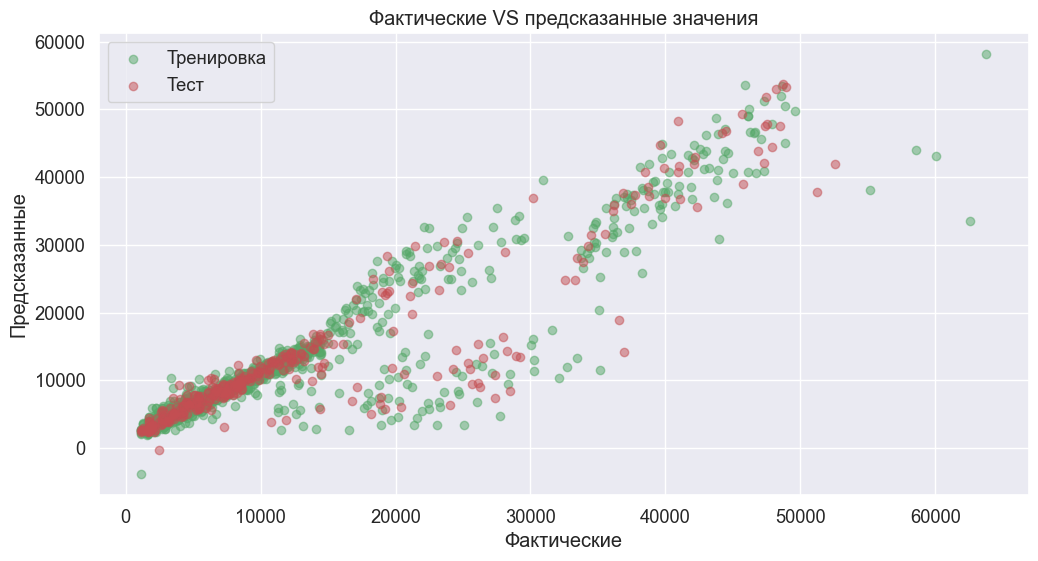

In [217]:
plt.scatter(Y_train, Y_train_pred, color = 'g', alpha = 0.5)
plt.scatter(Y_test, Y_test_pred, color = 'r', alpha = 0.5)
plt.title('Фактические VS предсказанные значения')
plt.xlabel('Фактические')
plt.ylabel('Предсказанные')
plt.legend(['Тренировка', 'Тест']);

#### **Итоги исследования**

Таким образом, в рамках настоящего проекта был проведен разведочный анализ данных (EDA), предобработаны категориальные признаки (sex, smoker, region), рассмотрены в том числе и посредством визуализации взаимосвязи признаков с целевой переменной (charges), благодаря чему были сделаны такие выводы как:
* Половая принадлженость практически не влияет на целевую переменную
* Чаще курящие пациенты тратят на медицинские услуги около 20 и 40 тысяч долларов в год
* У некурящих людей стоимость услуг увеличивается практически пропорционально возрасту в отличие от курящих
* Больше всего на медицинские услуги тратят курящие люди с высоким показателем индекса массы тела и др.  

В конце работы была построена модель линейной регрессии по методу наименьших квадратов, предсказывающая стоимость медицинских услуг в зависимости от наличия привычки курить, возраста, индекса массы тела, региона проживания пациентов и количества детелй в семье. Также было произведено разделение исходных данных на обучающую и тестовую выборки, что позволило обучить модель на одной части данных и проверить ее производительность на другой, независимой части. Для оценки качества работы первой модели были рассчитаны коэффициент детерминации ($R^2$) и абсолютная разница между данными прогноза и модели (MAE). Результат получился весьма неплохой, но ведь нет предела совершенству. Поэтому с целью улучшения работы модели было принято решение добавить полиномиальные переменные. Так, обе метрики были улучшены, модель стала объяснять практически 85% изменчивости нашей зависимой переменной со средней ошибкой в $3056